# Адаптированная копия нноутбука со статьи на habr.com

Статья: https://habr.com/ru/articles/655517/

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.6 MB/s eta 0:00:00


In [ ]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt

tqdm.pandas()

device = torch.device('cuda')

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.style.use('bmh')
# Переменные
path_ds2 = '/content/drive/MyDrive/Media108/DS2/'                # Папка с датасетами 2
path_ds = '/content/drive/MyDrive/Media108/DS/'                  # Папка с датасетами
path_dataset = '/content/drive/MyDrive/Media108/DATASET/'        # Обобщающая папка для датасетов
path_dir = '/content/drive/MyDrive/Media108/'                    # Общий путь для сохранения результатов
list_txt = ['DS/Расшифровки_Записи звонков_павелецкая сити',
            'DS/Расшифровки_Записи звонков_хедлайнер',
            'DS/Расшифровки_Записи звонков_primavera'
            'DS2/Расшифровки_Записи Павелецкая сити',
            'DS2/Расшифровки_Записи Headliner',
            'DS2/Расшифровки_Записи Primavera']                     # Папки с расшифровками разговоров
name_of_dir = ['DS/Записи звонков_павелецкая сити',
               'DS/Записи звонков_хедлайнер',
               'DS/Записи звонков_primavera'
               'DS2/Записи Павелецкая сити',
               'DS2/Записи Headliner',
               'DS2/Записи Primavera']                              # Папки с аудиозаписями  2

np.random.seed(42)

<Figure size 1200x600 with 0 Axes>

In [ ]:
df_all = pd.read_csv(path_dir+'df_new_3klass.csv')
df_all['Текст_whisper'] = df_all['Текст_whisper'].str.replace('ё', 'е', regex=False)
df = df_all[['Текст_whisper','Признак']].copy()
df = df.rename(columns={'Текст_whisper': 'text', 'Признак': 'target'})
df.shape

(6921, 2)

In [ ]:
bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-sentence')

In [ ]:
df.head()

,text,target
0,безответа,0
1,здравствуйте,0
2,здравствуйте вы позвонили в компанию эмргрупп ...,0
3,здравствуйте,0
4,здравствуйте вы позвонили в группу компании ка...,1


In [ ]:
tr_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])
train_df, test_df = train_test_split(tr_df, test_size=0.25, random_state=42, stratify=tr_df['target'])
train_df.shape[0], val_df.shape[0], test_df.shape[0]

(4152, 1385, 1384)

In [ ]:
all_txt = df['text'].astype('str')
all_labels = df['target']
train_text = train_df['text'].astype('str')
train_labels = train_df['target']
val_text = val_df['text'].astype('str')
val_labels = val_df['target']
test_text = test_df['text'].astype('str')
test_labels = test_df['target']

In [ ]:
train_labels

6689    0
2262    0
2284    0
2166    0
6388    1
       ..
2741    0
6765    0
6883    0
3951    1
1707    0
Name: target, Length: 4152, dtype: int64

In [ ]:
test_df.target.value_counts()

<Axes: >

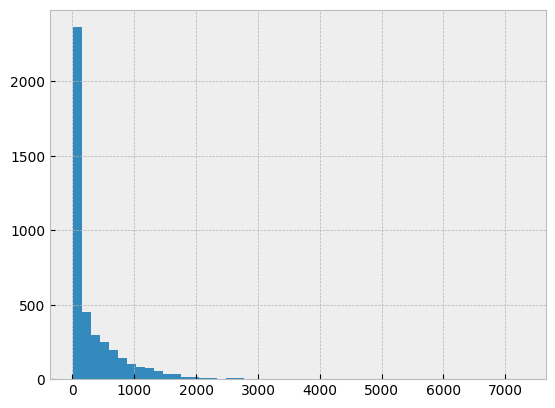

In [ ]:
seq_len = [len(str(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins = 50)

In [ ]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.values,
    max_length = 512,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.values,
    max_length = 512,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.values,
    max_length = 512,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)
batch_size = 8


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [ ]:
model = BERT_Arch(bert)

model = model.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(),
               lr= 1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes = np.unique(train_labels), y = train_labels)

print(class_weights)

weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss()
epochs = 25

[0.7446198  1.52199413]


In [ ]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [ ]:
bert.cuda()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [ ]:
best_valid_loss = float('inf')
best_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path_dir+'saved_weights.pt')
    if valid_loss == best_valid_loss:
        if train_loss < best_loss:
            best_loss = train_loss
            torch.save(model.state_dict(), path_dir+'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 25


100%|██████████| 174/174 [00:45<00:00,  3.80it/s]



Training loss: 0.374
Validation loss: 0.298

 Epoch2 / 25


100%|██████████| 174/174 [00:45<00:00,  3.82it/s]



Training loss: 0.347
Validation loss: 0.298

 Epoch3 / 25


100%|██████████| 174/174 [00:45<00:00,  3.79it/s]



Training loss: 0.338
Validation loss: 0.298

 Epoch4 / 25


100%|██████████| 174/174 [00:45<00:00,  3.79it/s]



Training loss: 0.328
Validation loss: 0.287

 Epoch5 / 25


100%|██████████| 174/174 [00:45<00:00,  3.82it/s]



Training loss: 0.332
Validation loss: 0.282

 Epoch6 / 25


100%|██████████| 174/174 [00:45<00:00,  3.79it/s]



Training loss: 0.330
Validation loss: 0.284

 Epoch7 / 25


100%|██████████| 174/174 [00:45<00:00,  3.80it/s]



Training loss: 0.319
Validation loss: 0.287

 Epoch8 / 25


100%|██████████| 174/174 [00:45<00:00,  3.79it/s]



Training loss: 0.319
Validation loss: 0.314

 Epoch9 / 25


100%|██████████| 174/174 [00:45<00:00,  3.80it/s]



Training loss: 0.312
Validation loss: 0.319

 Epoch10 / 25


100%|██████████| 174/174 [00:45<00:00,  3.80it/s]



Training loss: 0.315
Validation loss: 0.275

 Epoch11 / 25


100%|██████████| 174/174 [00:45<00:00,  3.80it/s]



Training loss: 0.309
Validation loss: 0.277

 Epoch12 / 25


100%|██████████| 174/174 [00:45<00:00,  3.79it/s]



Training loss: 0.312
Validation loss: 0.292

 Epoch13 / 25


100%|██████████| 174/174 [00:46<00:00,  3.78it/s]



Training loss: 0.307
Validation loss: 0.284

 Epoch14 / 25


100%|██████████| 174/174 [00:45<00:00,  3.80it/s]



Training loss: 0.304
Validation loss: 0.277

 Epoch15 / 25


100%|██████████| 174/174 [00:45<00:00,  3.80it/s]



Training loss: 0.303
Validation loss: 0.280

 Epoch16 / 25


100%|██████████| 174/174 [00:45<00:00,  3.80it/s]



Training loss: 0.308
Validation loss: 0.318

 Epoch17 / 25


100%|██████████| 174/174 [00:45<00:00,  3.80it/s]



Training loss: 0.301
Validation loss: 0.294

 Epoch18 / 25


100%|██████████| 174/174 [00:45<00:00,  3.81it/s]



Training loss: 0.303
Validation loss: 0.298

 Epoch19 / 25


100%|██████████| 174/174 [00:45<00:00,  3.81it/s]



Training loss: 0.304
Validation loss: 0.274

 Epoch20 / 25


100%|██████████| 174/174 [00:45<00:00,  3.81it/s]



Training loss: 0.292
Validation loss: 0.302

 Epoch21 / 25


100%|██████████| 174/174 [00:45<00:00,  3.81it/s]



Training loss: 0.299
Validation loss: 0.276

 Epoch22 / 25


100%|██████████| 174/174 [00:45<00:00,  3.81it/s]



Training loss: 0.292
Validation loss: 0.265

 Epoch23 / 25


100%|██████████| 174/174 [00:45<00:00,  3.79it/s]



Training loss: 0.292
Validation loss: 0.289

 Epoch24 / 25


100%|██████████| 174/174 [00:45<00:00,  3.81it/s]



Training loss: 0.291
Validation loss: 0.266

 Epoch25 / 25


100%|██████████| 174/174 [00:46<00:00,  3.78it/s]


Training loss: 0.294
Validation loss: 0.276


In [ ]:
path = path_dir+'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

Видеопамяти не хватает для хранения всего что в нее передано, поэтому используем костыль. Разобьем тестовые данные на части и будем отправлять на предсказание по частям

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

list_seq = np.array_split(test_seq, 50)
list_mask = np.array_split(test_mask, 50)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(device), list_mask[num].to(device))
        predictions.append(preds.detach().cpu().numpy())

In [ ]:
flat_preds = [item[1] for sublist in predictions for item in sublist]
flat_preds = (flat_preds - min(flat_preds)) / (max(flat_preds) - min(flat_preds))
test_df['confidence'] = flat_preds

На выходе мы получили значение с плавающей точкой от 0 до 1. Теперь меняя порог, мы сможем предсказать финальный класс:

In [ ]:
# Порог 0,95
test_df['pred'] = test_df['confidence'].apply(lambda x: 1 if x>0.95 else 0)

print(classification_report(test_df['target'], test_df['pred']))


              precision    recall  f1-score   support

           0       0.93      0.91      0.92       930
           1       0.82      0.86      0.84       454

    accuracy                           0.89      1384
   macro avg       0.87      0.88      0.88      1384
weighted avg       0.89      0.89      0.89      1384



In [ ]:
test_df.target.value_counts()

0    930
1    454
Name: target, dtype: int64

In [ ]:
test_df.pred.value_counts()

0    904
1    480
Name: pred, dtype: int64

In [ ]:
display(test_df[['target','pred','confidence']])

,target,pred,confidence
4933,0,0,0.331518
2326,0,0,0.795679
1452,0,0,0.677530
5338,0,0,0.269815
4771,1,1,0.998983
...,...,...,...
574,0,0,0.612054
1484,0,0,0.873948
4419,1,1,0.995170
938,0,0,0.581234


In [ ]:
# Порог 0,93
test_df['pred'] = test_df['confidence'].apply(lambda x: 1 if x>0.93 else 0)

print(classification_report(test_df['target'], test_df['pred']))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       930
           1       0.78      0.91      0.84       454

    accuracy                           0.89      1384
   macro avg       0.87      0.89      0.88      1384
weighted avg       0.90      0.89      0.89      1384



In [ ]:
test_df.pred.value_counts()

0    854
1    530
Name: pred, dtype: int64

In [ ]:
display(test_df[['target','pred','confidence']])

,target,pred,confidence
4933,0,0,0.331518
2326,0,0,0.795679
1452,0,0,0.677530
5338,0,0,0.269815
4771,1,1,0.998983
...,...,...,...
574,0,0,0.612054
1484,0,0,0.873948
4419,1,1,0.995170
938,0,0,0.581234
